In [1]:
import sys
sys.path.append('../')

import os
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import string 
import random

In [2]:
from wmdetection.dataset.synthetic_wm import *
from wmdetection.utils import list_images

## Define functions

#### Random string generators

In [3]:
def generate_random_string(length):
    return ''.join(random.choices(string.ascii_lowercase + string.ascii_uppercase + string.digits + ' ', k=length))

def generate_random_url(length, www_prob=0.5):
    suffixes = ('ru', 'en', 'com', 'su', 'net')
    random_s = ''.join(random.choices(string.ascii_lowercase*3 + string.digits + '-', k=length))
    url = random_s+'.'+random.choice(suffixes)
    if random.random() < www_prob:
        url = 'www.'+url
    return url

#### final watermark placers
change parameters or intervals if need

In [4]:
def diagonal_watermark(pil_image, text):
    return place_random_diagonal_watermark(
        pil_image, 
        text,
        random_step_x=(0.25, 0.4),
        random_step_y=(0.25, 0.4),
        random_angle=(-60,60),
        text_height_in_percent_range=get_text_height_in_percent_range(text),
        text_alpha_range=alpha_range,
        fonts=CV2_FONTS,
        font_thickness_range=font_thickness_range,
        colors=colors,
    )

def centered_watermark(pil_image, text):
    return place_random_centered_watermark(
        pil_image, 
        text,
        center_point_range_shift=(-0.025, 0.025),
        random_angle=(0,0),
        text_height_in_percent_range=get_text_height_in_percent_range(text),
        text_alpha_range=alpha_range,
        fonts=CV2_FONTS,
        font_thickness_range=font_thickness_range,
        colors=colors,
    )

def centered_angled_watermark(pil_image, text):
    return place_random_centered_watermark(
        pil_image, 
        text,
        center_point_range_shift=(-0.005, 0.005),
        random_angle=(-45,45),
        text_height_in_percent_range=get_text_height_in_percent_range(text),
        text_alpha_range=alpha_range,
        fonts=CV2_FONTS,
        font_thickness_range=font_thickness_range,
        colors=colors,
    )

def random_watermark(pil_image, text):
    return place_random_watermark(
        pil_image, 
        text,
        random_angle=(0,0),
        text_height_in_percent_range=get_text_height_in_percent_range(text),
        text_alpha_range=alpha_range,
        fonts=CV2_FONTS,
        font_thickness_range=font_thickness_range,
        colors=colors,
    )

def random_angled_watermark(pil_image, text):
    return place_random_watermark(
        pil_image, 
        text,
        random_angle=(-15,15),
        text_height_in_percent_range=get_text_height_in_percent_range(text),
        text_alpha_range=alpha_range,
        fonts=CV2_FONTS,
        font_thickness_range=font_thickness_range,
        colors=colors,
    )

#### Colors and text size
generation of color pallete to use and function of random text height generation based on text

In [5]:
import math

def create_color_palette():
    colors = []
    colors.extend([(i,i,i) for i in range(245, 255)]) # оттенки белого
    colors.extend([(i,i,i) for i in range(245, 255)]) # оттенки белого
    colors.extend([(i,i,i) for i in range(245, 255)]) # оттенки белого
    colors.extend([(i,i,i) for i in range(240, 255)]) # оттенки белого
    colors.extend([(i,i,i) for i in range(240, 255)]) # оттенки белого
    colors.extend([(i,i,i) for i in range(240, 255)]) # оттенки белого
    #
    colors.extend([(i,0,0) for i in range(245, 255)]) # оттенки красного
    colors.extend([(0,i,0) for i in range(245, 255)]) # оттенки зеленого
    colors.extend([[random.randint(210,255) for i in range(3)] for j in range(15)])
    return colors

def get_text_height_in_percent_range(text):
    if len(text) >= 7:
        k = len(text)/7
        text_height_start = max(0.06, 0.095/math.sqrt(k))
        text_height_end = max(0.10, 0.165/math.sqrt(k))
        res = (text_height_start, text_height_end)
        return res
    else:
        return (0.07, 0.135)
    
colors = create_color_palette()

In [6]:
# alpha channel interval for text
alpha_range = (0.35, 0.7)

# font thickness interval
font_thickness_range = (3, 7)

In [7]:
# watermark types chances

funtions = [
    random_watermark, random_angled_watermark,
    centered_watermark, centered_angled_watermark,
    diagonal_watermark
]

chances = [0.2, 0.05, 0.3, 0.15, 0.3]
assert sum(chances) == 1

#### text parameters

In [8]:
# words to use in watermarks
fixed_texts = ['gettyimages', 'photocase', 'freepik', 'BIGSTOCK', 'pexels', 'pixabay', 
               'lori', 'lori.ru', 'stockfresh', 'www.acrylical.com', 'ebay', 'AVITO', 'dreamstime',
               'AdobeStock', 'envatoelemants', 'fineart']

# url length interval
url_len_range = [3, 8]

# text length interval
text_len_range = [6, 12]

In [9]:
# text types chances

url_chance = 0.3
text_chance = 0.4
fixed_chance = 0.3

assert sum([url_chance, text_chance, fixed_chance]) == 1

## Test on single image

In [10]:
from glob import glob
import os

def resize_by_max(img, size=600):
    maxind = 0 if img.size[0]>img.size[1] else 1
    rescale = size/img.size[maxind]
    return img.resize([int(i*rescale) for i in img.size])

def get_random_text():
    t = np.random.choice(['url', 'text', 'fixed'], p=[url_chance, text_chance, fixed_chance])
    
    if t == 'url':
        url_len = random.randint(*url_len_range)
        return generate_random_url(url_len)
    elif t == 'text':
        text_len = random.randint(*text_len_range)
        return generate_random_string(text_len)
    else:
        return random.choice(fixed_texts)
    
def generate_watermark(img):
    watermark_func = np.random.choice(funtions, 1, p=chances)[0]
    img_resized = resize_by_max(img, size=600)
    return watermark_func(img_resized, get_random_text())

In [11]:
filenames = list_images('../images/clean/')
filenames

['../images/clean/1.jpg',
 '../images/clean/2.jpg',
 '../images/clean/3.jpg',
 '../images/clean/4.jpg',
 '../images/clean/5.jpg',
 '../images/clean/6.jpg']

In [12]:
img = Image.open(random.choice(filenames))

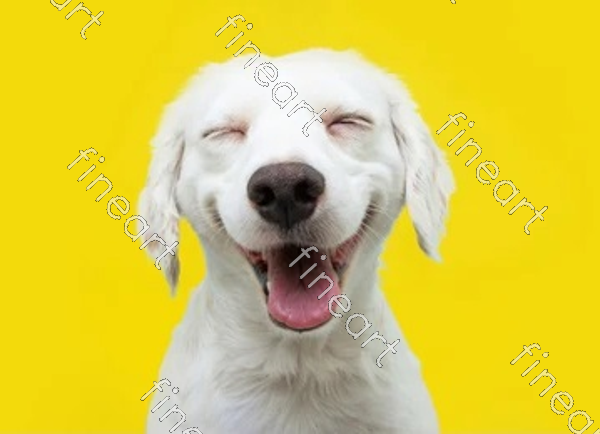

In [15]:
generate_watermark(img)

## Run generation of synthetic dataset

Gather clean images for generator

In [13]:
clean_folders = [
    ('../images/clean/', 5),
    # add your folders and images count
]

folder2images = {f: random.sample(list_images(f), k=count) for f, count in clean_folders}

In [14]:
all_paths = []

for imgs in folder2images.values():
    all_paths.extend(imgs)
    
len(all_paths)

5

### run generation

In [15]:
# directory there result images will be saved
dir_save_to = "../dataset/synthetic_wm"

In [16]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm.contrib.concurrent import process_map

os.makedirs(dir_save_to, exist_ok=True)

def create_wm_image(filepath):
    image = Image.open(filepath)
    new_filename = filepath.replace('/', '_').lstrip('.')
    wm_img = generate_watermark(image)
    wm_img.save(os.path.join(dir_save_to, new_filename))

In [17]:
process_map(create_wm_image, all_paths, max_workers=16)

  0%|          | 0/5 [00:00<?, ?it/s]

[None, None, None, None, None]

### Check generated samples

In [18]:
syn_imgs = list_images(dir_save_to)
len(syn_imgs)

5

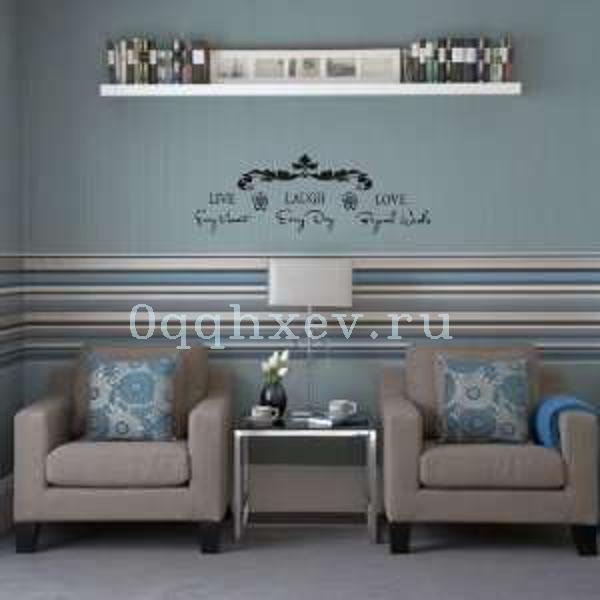

In [19]:
path = random.choice(syn_imgs)
Image.open(path)